# Validation of DeepLIFT bases with CENTIPEDE motifs


# Scoring TF motifs with DeepLIFT

Figure goals from this analysis:
1. Arrow-shape plots of deepLIFT score vs. nucleotide position relative to motif center for activating motifs, similar v-shape plots for repressive motifs. (analogous to Sharpr Figure 4b).
2. Bar plots comparing average deepLIFT score in real TF motifs vs. shuffled TF motifs.
3. Scatter plot showing motif average score in HepG2 cells vs. K562 cells - cell-type specific TF activity. (analogous to Sharpr Figure 4a.)
4. Potentially, analysis of motifs with dual activator-repressor function. Not yet sure about visualization.

First going to try using training set only. That is, compute average score for all motifs that completely overlap a Sharpr fragment in the training set. Here are the steps to do so:
1. Convert Pouya Kheradpour's motif matches file (http://compbio.mit.edu/encode-motifs/) to BED format 1a. Get motif matches on chr1 from the converted BED file
2. Convert split file to BED format - only chromosome 1
3. bedtools intersect -a matches-with-controls-bed-chr1.txt.gz -b $DL/splits/sharpr_znormed_jul23/chr1_train_indexed_bed.txt -wa -wb -f 1 -s > sharpr_motif_intersection_chr1.txt.gz
4. Create a dictionary where the keys are motifs and the values are 2D arrays of the scores where rows are motif instances and columns are scores for each base pair in the motif. Will start with no keys/values, add keys as each new motif comes in.
4a. Create a second dictionary that gets deeplift scores for the broader context around the motif to show the characteristic arrow shape that the Sharpr paper shows. 
5. Each line in the sharpr_motif_intersection is a specific motif in a specific sharpr fragment. Iterate through said file, getting the index from the score column of the sharpr fragment, and getting the start coordinate of the sharpr fragment from the start column as well. Then, the deeplift score indices will be:
deepliftscores[task_idx][fragment_idx][(motif_start - fragment_start) : (motif_end - fragment_start)]
(there may be an off-by-one error here if the two use different coordinate systems, but that should be noticeable / ok.)
Check if the motif_start - 50 > fragment_start and motif_end + 50 < fragment_end. If so, get deeplift scores for 
deepliftscores[task_idx][fragment_idx][(motif_start - fragment_start - 50) : (motif_end - fragment_start + 50)]
and put those into the second dictionary.

6. For each motif, compute average scores across numpy axis 1 - at each base pair relative to motif center, what's the avg score. Should drop off with increasing distance from motif center. This is using the -50 +50bp dictionary.

7. seaborn.tsplot of dictionary 2 for Figure Goal 1; seaborn.scatterplot of dictionary 1 for Figure Goal 3; cherry pick some of the top motifs and do seaborn.barplot for figure goal 2



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import avutils
from avutils import file_processing as fp
import numpy as np
from collections import OrderedDict
from deeplift.blobs import NonlinearMxtsMode, DenseMxtsMode
import deeplift
import deeplift.conversion.keras_conversion as kc
from deeplift.visualization import viz_sequence
import os, sys
import pandas as pd

/home/users/rmovva/anaconda2/envs/mommadragonn/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda: Tesla P100-PCIE-16GB (0000:04:00.0)


In [ ]:
modelName = "record_13_model_bgGhy_"
modelJson = "../model_files/sharpr_znormed_jul23/" + modelName + "modelJson.json"
modelWeights = "../model_files/sharpr_znormed_jul23/" + modelName + "modelWeights.h5"

keras_model = kc.load_keras_model(modelWeights, json=modelJson)

# normalize weights
W, b = keras_model.layers[0].get_weights()
mean_W = np.mean(W, axis = -2)
W = W - mean_W[:, :, None, :]
b = b + np.squeeze(np.sum(mean_W,axis=0))
keras_model.layers[0].set_weights([W, b])

import momma_dragonn
import h5py
# load the validation set
train_path = "../hdf5files/sharpr_znormed_jul23/train_data.hdf5"
data = h5py.File(train_path)

deeplift_model = kc.convert_sequential_model(keras_model,
                                             nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT_GenomicsDefault)

deeplift_prediction_function = deeplift_model.get_prediction_function(input_layer_idx = 0,
                                                                      output_layer_idx = -1
                                                                     )

preds = deeplift_prediction_function([data['X/sequence']], batch_size = 500)

deeplift_scoring_func = deeplift_model.get_target_contribs_func(find_scores_layer_idx = 0,
                                                                target_layer_idx = -1
                                                               )

letter_list = ['A', 'C', 'G', 'T']

def convert_one_hot_seq_to_acgt(one_hot_seq):
    seq = ''
    for i in range(len(one_hot_seq)):
        seq += letter_list[np.argmax(one_hot_seq[i])]
    return seq

In [ ]:
modelName = "record_13_model_bgGhy_"
modelJson = "../model_files/sharpr_znormed_jul23/" + modelName + "modelJson.json"
modelWeights = "../model_files/sharpr_znormed_jul23/" + modelName + "modelWeights.h5"

keras_model = kc.load_keras_model(modelWeights, json=modelJson)

# normalize weights
W, b = keras_model.layers[0].get_weights()
mean_W = np.mean(W, axis = -2)
W = W - mean_W[:, :, None, :]
b = b + np.squeeze(np.sum(mean_W,axis=0))
keras_model.layers[0].set_weights([W, b])

import momma_dragonn
import h5py
# load the validation set
train_path = "../hdf5files/sharpr_znormed_jul23/train_data.hdf5"
data = h5py.File(train_path)

deeplift_model = kc.convert_sequential_model(keras_model,
                                             nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT_GenomicsDefault)

deeplift_prediction_function = deeplift_model.get_prediction_function(input_layer_idx = 0,
                                                                      output_layer_idx = -1
                                                                     )

preds = deeplift_prediction_function([data['X/sequence']], batch_size = 500)

deeplift_scoring_func = deeplift_model.get_target_contribs_func(find_scores_layer_idx = 0,
                                                                target_layer_idx = -1
                                                               )

In [6]:
letter_list = ['A', 'C', 'G', 'T']

def convert_one_hot_seq_to_acgt(one_hot_seq):
    seq = ''
    for i in range(len(one_hot_seq)):
        seq += letter_list[np.argmax(one_hot_seq[i])]
    return seq

import time
t0 = time.time()
input_data_sequences = []
print_interval = int(1e5)
for (i, seq) in enumerate(np.array(data['X/sequence'])):
    if i % print_interval == 0 and i > 0:
        print ("Converting sequences " + str(i - print_interval) +
               " to " + str(i) + " from one-hot to ACGT strings took " +
               str(round(time.time() - t0, 3)) + "s.")
        t0 = time.time()
    char_seq = convert_one_hot_seq_to_acgt(seq)
    input_data_sequences.append(char_seq)
    
input_data_sequences = np.array(input_data_sequences)

import avutils
from deeplift.dinuc_shuffle import dinuc_shuffle

seed = 0
deeplift_many_refs_func = deeplift.util.get_shuffle_seq_ref_function(
                                score_computation_function=deeplift_scoring_func, #supply any deeplift scoring function
                                shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
                                seed=seed,
                                one_hot_func=lambda x: np.array([avutils.util.seq_to_one_hot(seq) for seq in x]) #theano_seq_to_2d_image, seq_to_one_hot
                            )

task_idxs = [2, 5, 8, 11] # 'average' tasks for k5minp, k5sv40, hepminp, hepsv40 respectively

task_to_deeplift_contribs = OrderedDict()
for task_idx in task_idxs:
    task_to_deeplift_contribs[task_idx] = np.array(deeplift_many_refs_func(
                                                      task_idx = task_idx,
                                                      input_data_sequences=input_data_sequences,
                                                      num_refs_per_seq=8,
                                                      batch_size=500,
                                                      progress_update=1000000))

Converting sequences 0 to 100000 from one-hot to ACGT strings took 32.533s.
Converting sequences 100000 to 200000 from one-hot to ACGT strings took 17.174s.
Converting sequences 200000 to 300000 from one-hot to ACGT strings took 17.488s.
Converting sequences 300000 to 400000 from one-hot to ACGT strings took 17.479s.
Converting sequences 400000 to 500000 from one-hot to ACGT strings took 17.513s.
Converting sequences 500000 to 600000 from one-hot to ACGT strings took 17.536s.
Converting sequences 600000 to 700000 from one-hot to ACGT strings took 17.55s.
Converting sequences 700000 to 800000 from one-hot to ACGT strings took 17.412s.
Converting sequences 800000 to 900000 from one-hot to ACGT strings took 17.376s.
1000000 reference seqs generated
2000000 reference seqs generated
3000000 reference seqs generated
4000000 reference seqs generated
5000000 reference seqs generated
6000000 reference seqs generated
7000000 reference seqs generated
One hot encoding sequences...
One hot encoding

In [10]:
print task_to_deeplift_contribs[2].shape

task_to_deeplift_summedscores = OrderedDict()
for task_idx in task_to_deeplift_contribs:
    task_to_deeplift_summedscores[task_idx] = np.sum(task_to_deeplift_contribs[task_idx], axis=-1)
    
print task_to_deeplift_summedscores[2].shape

(914348, 145, 4)
(914348, 145)


In [190]:
import time

motif_scores = OrderedDict()
motifwcontext_scores = OrderedDict()
for task_idx in task_to_deeplift_summedscores:
    motif_scores[task_idx] = {}
    motifwcontext_scores[task_idx] = {}

motifPath = '/scratch/users/rmovva/mpra/data/pouya_motif_matches/'
motifsToScore = open(motifPath + 'sharprtrain_motif_intersection_all.txt', 'r')
i = 0
t0 = time.time()
progress_update = 2000000
previous_motif = ('', '')
for motif in motifsToScore:
    if i % progress_update == 0 and i > 0:
        print("Scoring motifs %d to %d took %.3f s" % (i - progress_update, i, time.time() - t0))
        t0 = time.time()
    motif = motif.strip().split('\t')
    motif_start = int(motif[1])
    motif_end = int(motif[2])
    motif_name = motif[3]
#     # Prevent duplicate scoring of a motif with a different tile's deeplift scores
#     if motif_name == previous_motif[0] and motif_start == previous_motif[1]:
#         i += 1
#         continue
#     previous_motif = (motif_name, motif_start)
    fragment_start = int(motif[7])
    fragment_end = int(motif[8])
    fragment_idx = int(motif[-2])
    
    canGetContext = (motif_start - fragment_start >= 50 and motif_end + 50 <= fragment_end)
    
    for task_idx in motif_scores:
        if motif_name not in motif_scores[task_idx]:
            motif_scores[task_idx][motif_name] = []
        scores = task_to_deeplift_summedscores[task_idx][fragment_idx][(motif_start - fragment_start) : (motif_end - fragment_start)]
        motif_scores[task_idx][motif_name].append(scores)
        
        if canGetContext:
            if motif_name not in motifwcontext_scores[task_idx]:
                motifwcontext_scores[task_idx][motif_name] = []
            context_start = motif_start - fragment_start - 50
            context_end = motif_end - fragment_start + 50
            scores = task_to_deeplift_summedscores[task_idx][fragment_idx][context_start : context_end]
            motifwcontext_scores[task_idx][motif_name].append(scores)
    i += 1

motifsToScore.close()
            
for task_idx in motif_scores:
    for motif_name in motif_scores[task_idx]:
        motif_scores[task_idx][motif_name] = np.array(motif_scores[task_idx][motif_name])
        
    for motif_name in motifwcontext_scores[task_idx]:
        motifwcontext_scores[task_idx][motif_name] = np.array(motifwcontext_scores[task_idx][motif_name])
        

Scoring motifs 0 to 2000000 took 20.328
Scoring motifs 2000000 to 4000000 took 18.764
Scoring motifs 4000000 to 6000000 took 18.818
Scoring motifs 6000000 to 8000000 took 18.837
Scoring motifs 8000000 to 10000000 took 19.125
Scoring motifs 10000000 to 12000000 took 19.142
Scoring motifs 12000000 to 14000000 took 18.634
Scoring motifs 14000000 to 16000000 took 19.312


In [191]:
for task_idx in [2]:
    print("Number of motifs without context in >= 1 fragment: %d" % len(motif_scores[task_idx].keys()) )
    print("Number of motifs with 50bp context in >= 1 fragment: %d" % len(motifwcontext_scores[task_idx].keys()) )
    meanWoContext = np.mean(np.array([len(motif_scores[task_idx][motif_name]) for motif_name in motif_scores[task_idx]]))
    print("Average number of instances of motifs without context: %.3f" % meanWoContext)
    meanWContext = np.mean(np.array([len(motifwcontext_scores[task_idx][motif_name]) for motif_name in motifwcontext_scores[task_idx]]))
    print("Average number of instances of motifs with 50bp context: %.3f" % meanWContext)

Number of motifs without context in >= 1 fragment: 18862
Number of motifs with 50bp context in >= 1 fragment: 18856
Average number of instances of motifs without context: 867.067
Average number of instances of motifs with 50bp context: 216.796


In [192]:
for motif_name in motif_scores[2]:
    if motif_name.find('NRF1_disc2') != -1:
        print motif_name, len(motif_scores[2][motif_name])

NRF1_disc2 256
NRF1_disc2_C1 161
NRF1_disc2_C3 352
NRF1_disc2_C4 215
NRF1_disc2_C5 168
NRF1_disc2_C6 251
NRF1_disc2_C7 255
NRF1_disc2_C2 256
NRF1_disc2_C8 216


In [193]:
# contains the average deepLIFT scores for each instance of the motif - gives distribution of motif scores
average_motif_scores = OrderedDict() 
# contains the average deepLIFT score across all instances of the motif at each base pair in the motif
average_motif_scores_bp = OrderedDict()
# contains the average deepLIFT score across all instances of the motif + 50bp context
average_motifwcontext_scores_bp = OrderedDict()

for task_idx in motif_scores:
    print("On task %d" % task_idx)
    average_motif_scores[task_idx] = {}
    average_motif_scores_bp[task_idx] = {}
    average_motifwcontext_scores_bp[task_idx] = {}
    for motif_name in motif_scores[task_idx]:
        average_motif_scores[task_idx][motif_name] = np.mean(motif_scores[task_idx][motif_name], axis=1)
        average_motif_scores_bp[task_idx][motif_name] = np.mean(motif_scores[task_idx][motif_name], axis=0)
    for motif_name in motifwcontext_scores[task_idx]:
        average_motifwcontext_scores_bp[task_idx][motif_name] = np.mean(motifwcontext_scores[task_idx][motif_name], axis=0)

On task 2
On task 5
On task 8
On task 11


In [194]:
# for each motif, take average of deeplift scores across all positions across all instances
# this gives a score for each combination of (TF motif, celltype, promoter)
# can then sort the TFs by score to find most activating and most repressing
aggregate_motif_scores = OrderedDict()

for task_idx in motif_scores:
    aggregate_motif_scores[task_idx] = [(motif_name, np.mean(average_motif_scores[task_idx][motif_name])) 
                                        for motif_name in average_motif_scores[task_idx]
                                        if motif_name.find('_C') == -1]
    aggregate_motif_scores[task_idx] = sorted(aggregate_motif_scores[task_idx],
                                                  key = lambda x: x[1])[::-1]

In [343]:
n_print = 10
for task_idx in aggregate_motif_scores:
    print("On task %d, activating" % task_idx)
    for i in range(n_print):
        print(aggregate_motif_scores[task_idx][i])
    print
    print("On task %d, repressive" % task_idx)
    for i in range(n_print):
        print(aggregate_motif_scores[task_idx][-(i+1)])
    print

On task 2, activating
('EP300_disc4', 0.06955865)
('TATA_disc3', 0.069153391)
('BRCA1_disc1', 0.066059388)
('NR3C1_disc3', 0.065597735)
('ETS_known12', 0.060823549)
('ELK3_1', 0.060823549)
('ELK3_2', 0.060823549)
('ETS_disc2', 0.060496386)
('ETS_known11', 0.060124218)
('ZBTB33_disc1', 0.05785843)

On task 2, repressive
('TCF12_disc1', -0.0085252244)
('ZEB1_known3', -0.0068636839)
('SNAI2_1', -0.0067555215)
('REST_disc2', -0.0066968161)
('CUX1_3', -0.0066482606)
('BCL_disc3', -0.0065688188)
('ID4_1', -0.0062496914)
('TBX5_2', -0.0062261396)
('HIC1_5', -0.006113553)
('SIN3A_disc3', -0.0060614957)

On task 5, activating
('TATA_disc3', 0.044083439)
('EP300_disc4', 0.043973278)
('BRCA1_disc1', 0.041379754)
('NR3C1_disc3', 0.040922686)
('ETS_known12', 0.038558103)
('ELK3_1', 0.038558103)
('ELK3_2', 0.038558103)
('ETS_disc2', 0.038302287)
('ETS_known11', 0.038191602)
('ZBTB33_disc1', 0.036989607)

On task 5, repressive
('SNAI2_1', -0.0046965759)
('TBX5_2', -0.0041167289)
('TCF12_disc1', -0.00

In [196]:
print np.mean(average_motif_scores[2]['ETS_1']), np.std(average_motif_scores[2]['ETS_1'])
print np.mean(average_motif_scores[2]['ETS_1_C1']), np.std(average_motif_scores[2]['ETS_1_C1'])
print np.mean(average_motif_scores[2]['GATA_known21']), np.std(average_motif_scores[2]['GATA_known21'])
print np.mean(average_motif_scores[2]['GATA_known21_C1']), np.std(average_motif_scores[2]['GATA_known21_C1'])
print np.mean(average_motif_scores[8]['HNF4_known3']), np.std(average_motif_scores[8]['HNF4_known3'])
print np.mean(average_motif_scores[8]['HNF4_known3_C4']), np.std(average_motif_scores[8]['HNF4_known3_C4'])
print np.mean(average_motif_scores[8]['REST_disc2']), np.std(average_motif_scores[8]['REST_disc2'])
print np.mean(average_motif_scores[8]['REST_disc2_C1']), np.std(average_motif_scores[8]['REST_disc2_C1'])
print np.mean(average_motif_scores[8]['SIN3A_disc7']), np.std(average_motif_scores[8]['SIN3A_disc7'])
print np.mean(average_motif_scores[8]['SIN3A_disc7_C1']), np.std(average_motif_scores[8]['SIN3A_disc7_C1'])

0.00929078 0.00842241
-0.000497909 0.00378683
0.00731715 0.00319154
0.00573436 0.00366916
0.00661717 0.00540624
-0.00136068 0.00284899
-0.00545936 0.00349258
-0.000327346 0.00280463
-4.09127e-05 0.00414636
0.00292928 0.00580864


In [197]:
print motifwcontext_scores[2]['ETS_1'].shape

(1079, 111)


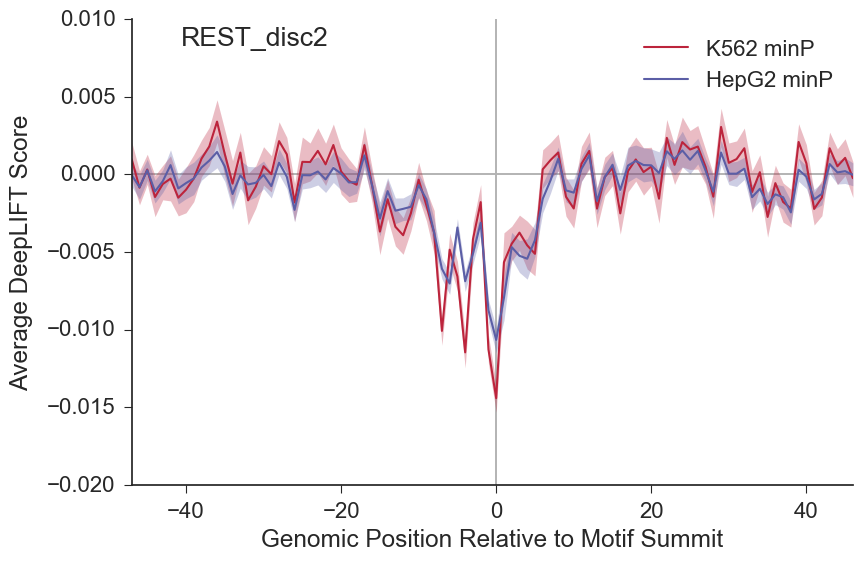

In [541]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

task_names = {2: 'K562 minP', 5: 'K562 SV40P', 8: 'HepG2 minP', 11: 'HepG2 SV40P'}

plt.figure(figsize=(9,6), dpi=300)
# sns.set(font_scale=1)
sns.set(context='paper', 
        style='ticks', 
#         palette=sns.color_palette("Set1", n_colors=8, desat=.8), 
        font='Arial', 
        font_scale=2, 
        color_codes="dark",
        )
task_idxs = [2,8]
# motif_names = ['GATA_disc1', 'GATA_disc1_C1']
motif_names = ['REST_disc2']#, 'ETS_1_C1']
# motif_names = ['HNF4_known3', 'HNF4_known3_C4']
# colors = ['#ff7913', '#88b04b', 'b', 'c']
# colors = ['r', 'b', 'b', 'c']
colors = ['#BC243C', '#5B5EA6', 'b', 'c']
conditions = list(itertools.product(task_idxs, motif_names))
context_scores_by_motif = [motifwcontext_scores[task_idx][motif_name] 
                           for (task_idx, motif_name) in conditions]
context_len = 50
offset = 6
context_len -= offset/2
for (i, context_scores) in enumerate(context_scores_by_motif):
#     print context_scores.shape
    length = context_scores.shape[1]
    ax = sns.tsplot(context_scores[:, (length/2 - context_len + offset/2):(length/2 + context_len + offset/2)], 
#                     time = np.arange(-1*length/2, length/2),
                    time = np.arange(-context_len, context_len),
                    value = 'Average DeepLIFT Score',
                    condition =  task_names[conditions[i][0]],
                    color = colors[i],
                    ci = 95,
#                     ci = 'sd',
                    n_boot = 1000,
                    err_style = 'ci_band',
                    err_kws = {'linewidth': 0, 'alpha': 0.3},
#                     err_palette = sns.color_palette("Set1", n_colors=8, desat=.8),
                    interpolate = True,
                    linewidth = 1.5
                   )
    
# print ax.__dict__
# plt.legend()
ax.text(0.17, 0.96, conditions[0][1],
        ha = 'center', va = 'center',
        transform = ax.transAxes)
plt.xticks([-40, -20, 0, 20, 40])
# plt.yticks(np.arange(-0.02, 0.011, 0.005))
plt.axvline(0, zorder = -5, color = '#B3B3B3')
plt.axhline(0, zorder = -5, color = '#B3B3B3')
plt.xlabel('Genomic Position Relative to Motif Summit')
sns.despine(offset=0);
ax.yaxis.labelpad=10
plt.tight_layout()
plt.savefig('../model_files/sharpr_znormed_jul23/interpretation/motifscore_arrowplots/' + 
            '%s_tasks%s.png' % (conditions[0][1], 'and'.join([str(i) for i in task_idxs])), 
            dpi=300)
plt.show()

In [485]:
# Create scatter plot of all motif scores
# Here the scores are the total avg deepLIFT scores over the entire motif

task_sets = [[2,5], [8,11]]
motif_names_list = []
motif_scores_set1 = []
motif_scores_set2 = []
selected_idxs = []
freeze_motifs = ['ETS_known12', 'BRCA1_disc1', 'AP1_known3', # activators
                 'SIN3A_disc1', 'REST_known4', # repressors
                 'RUNX1_6', 'GATA_known16', # k562-specific
                 'HNF4_disc1', 'TP53_2' # hepg2-specific
                ]
freeze_idxs = []
real_motif_idx = -1
for (i, motif_name) in enumerate(average_motif_scores_bp[task_sets[0][0]].keys()):
    if motif_name.find('_C') != -1:
        continue
    real_motif_idx += 1
    motif_names_list.append(motif_name)
    score_1 = np.mean([np.sum(average_motif_scores_bp[task_idx][motif_name]) for task_idx in task_sets[0]])
    score_2 = np.mean([np.sum(average_motif_scores_bp[task_idx][motif_name]) for task_idx in task_sets[1]])
    motif_scores_set1.append(score_1)
    motif_scores_set2.append(score_2)
    if (
        (score_1 > 0.2 and score_2 > 0.2 and score_1 < 0.3 and score_2 < 0.3)
        or (score_1 < -0.03 and score_2 < -0.03) 
        or (np.abs(score_1) > 6*np.abs(score_2) and np.abs(score_1) > 0.035)
        or (6*np.abs(score_1) < np.abs(score_2) and np.abs(score_2) > 0.05)
       ):
        selected_idxs.append(real_motif_idx)
#         print motif_name
#         print score_1
#         print score_2
    if motif_name in freeze_motifs:
        freeze_idxs.append(real_motif_idx)
            
motif_scores_set1 = np.array(motif_scores_set1)
motif_scores_set2 = np.array(motif_scores_set2)
print len(motif_scores_set1)
print len(motif_scores_set2)
print len(selected_idxs)

1934
1934
97


SpearmanrResult(correlation=0.86561904548364899, pvalue=0.0)


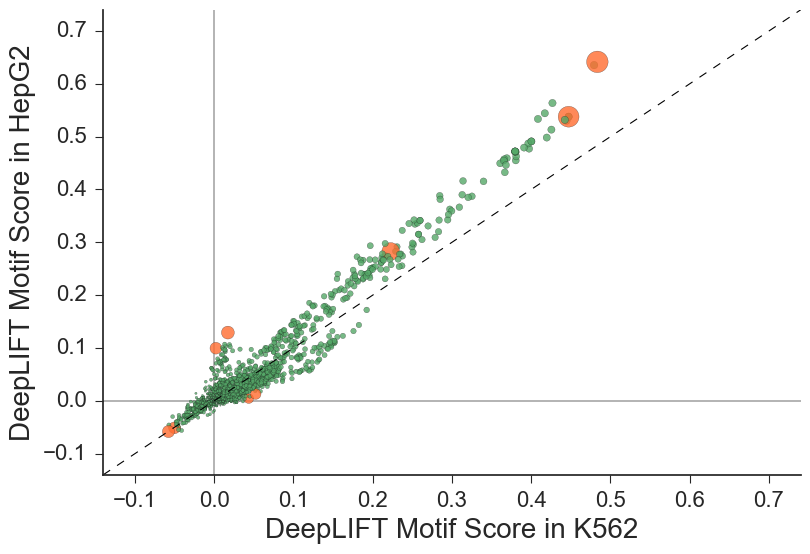

In [500]:
from plot_functions import jointplot, regplot
from scipy.stats import spearmanr

plt.figure(figsize=(9,6),dpi=300)

sns.set(context='paper', 
        style='ticks', 
        font='Arial', 
        font_scale=2, 
        color_codes="dark",
        )

# show_idxs = np.random.choice(selected_idxs, 5, replace=False)
show_idxs = freeze_idxs
# colorlist = ['#ff5913' if idx in show_idxs else 'g' for idx in range(len(motif_scores_set1))]
colorlist = ['#FF6C2F' if idx in show_idxs else 'g' for idx in range(len(motif_scores_set1))]
sizelist = 2*np.sqrt(200.0*np.abs(motif_scores_set1 + motif_scores_set2))
for idx in show_idxs:
    sizelist[idx] *= 8

print spearmanr(motif_scores_set1, motif_scores_set2)
    
ax = sns.regplot(x = motif_scores_set1, y = motif_scores_set2,
            fit_reg = False,
            scatter_kws = {
#                            's': 2*np.sqrt(200.0*np.abs(motif_scores_set1 + motif_scores_set2)),
                           's': sizelist,
                           'alpha' : 0.8,
#                            'color': '#ff7913', # orange
#                            'color': '#88b04b', # greenery
#                            'color': 'g', # greenery
                           'color': colorlist,
                           'edgecolor': 'k',
                           'linewidth': 0.2
#                            'edgecolors': len(motif_scores_set1)*['k']
                          }
           )

axlim = [-0.14, 0.74]
ax.set_xlim(axlim)
ax.set_ylim(axlim)
ax.plot(axlim, axlim, linestyle='--', color='black', linewidth = 0.8)

plt.axvline(0, zorder = -5, color = '#B3B3B3')
plt.axhline(0, zorder = -5, color = '#B3B3B3')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

# for idx in show_idxs:
#     ax.annotate(motif_names_list[idx], (motif_scores_set1[idx], motif_scores_set2[idx]), fontsize=12)
    
# ax.annotate('origin', (0,0))

# ax.set_xlabel('DeepLIFT Motif Score in K562', fontsize = 20, color = '#BC243C')
# ax.set_ylabel('DeepLIFT Motif Score in HepG2', fontsize = 20, color = '#5B5EA6')
ax.set_xlabel('DeepLIFT Motif Score in K562', fontsize = 20)
ax.set_ylabel('DeepLIFT Motif Score in HepG2', fontsize = 20)

sns.despine()

plt.savefig('../model_files/sharpr_znormed_jul23/interpretation/motifscore_scatterplots/' + 
            'K562vsHepG2_scatterplot_scaledpoints_unlabeled_uncoloredaxlabels.png',
            dpi=300)
plt.show()

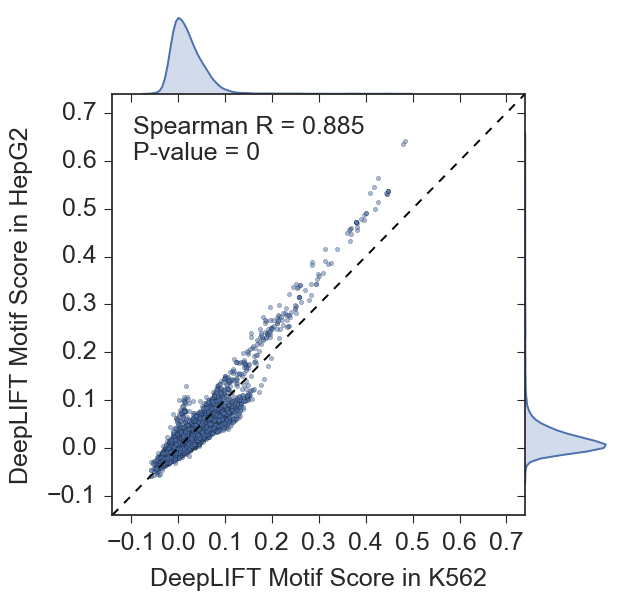

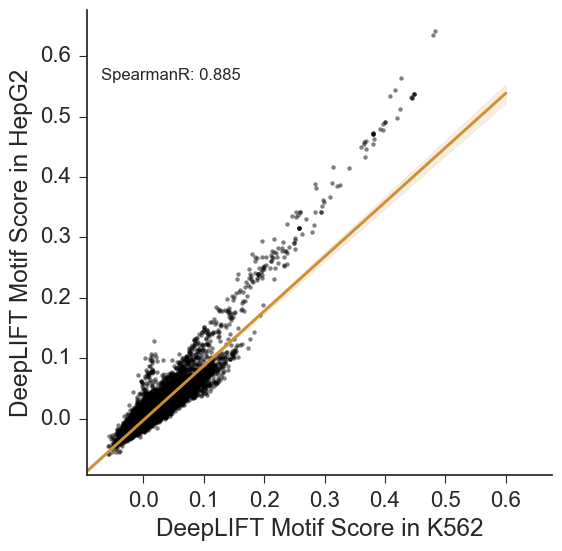

In [410]:
jointplot(np.array(motif_scores_set1), 
          np.array(motif_scores_set2),
          out_pdf = '../model_files/sharpr_znormed_jul23/interpretation/motifscore_scatterplots/' + 
                    'K562vsHepG2_jointplot.png',
          show=True,
          square=True,
          despine=False,
          cor='spearmanr',
          x_label='DeepLIFT Motif Score in K562',
          y_label='DeepLIFT Motif Score in HepG2',
          figsize=6,
          axlim=[-0.14, 0.74],
          color = 'b')

regplot(np.array(motif_scores_set1), 
        np.array(motif_scores_set2),
        out_pdf = '../model_files/sharpr_znormed_jul23/interpretation/motifscore_scatterplots/' + 
                  'K562vsHepG2_regplot.png',
        show=True,
        square=True,
#         despine=False,
        cor='spearmanr',
        x_label='DeepLIFT Motif Score in K562',
        y_label='DeepLIFT Motif Score in HepG2',
        figsize=(6,6))